In [1]:
import numpy as np 
import pandas as pd 
import cv2 as cv 
import tensorflow as tf 
import keras 
from matplotlib import pyplot as plt 
import seaborn as sns  
import sklearn as sk

2024-04-13 08:47:26.793194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 08:47:26.793307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 08:47:26.920778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
rd=pd.read_csv(r'/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Training_LesionGroupings_WithoutDuplicates_Merged.csv')
df_lesion_grouping=pd.DataFrame(rd)
df_lesion_grouping.head(10)

image    lesion_id            diagnosis_confirm_type  MEL   NV  BCC  \
0  ISIC_0028498  HAM_0000000                    histopathology  0.0  1.0  0.0   
1  ISIC_0027859  HAM_0000001                    histopathology  0.0  0.0  0.0   
2  ISIC_0034246  HAM_0000002                    histopathology  1.0  0.0  0.0   
3  ISIC_0027886  HAM_0000003  serial imaging showing no change  0.0  1.0  0.0   
4  ISIC_0024645  HAM_0000004  serial imaging showing no change  0.0  1.0  0.0   
5  ISIC_0030591  HAM_0000005                    histopathology  0.0  0.0  0.0   
6  ISIC_0034162  HAM_0000006                    histopathology  1.0  0.0  0.0   
7  ISIC_0033879  HAM_0000007     single image expert consensus  0.0  1.0  0.0   
8  ISIC_0029868  HAM_0000008  serial imaging showing no change  0.0  1.0  0.0   
9  ISIC_0029779  HAM_0000009                    histopathology  0.0  0.0  1.0   

   AKIEC  BKL   DF  VASC  fold_number  
0    0.0  0.0  0.0   0.0          4.0  
1    0.0  1.0  0.0   0.0          7.0  
2    0.0  0.0  0.0   0.0          8.0  
3    0.0  0.0  0.0   0.0         10.0  
4    0.0  0.0  0.0   0.0          9.0  
5    1.0  0.0  0.0   0.0          7.0  
6    0.0  0.0  0.0   0.0          4.0  
7    0.0  0.0  0.0   0.0          9.0  
8    0.0  0.0  0.0   0.0          2.0  
9    0.0  0.0  0.0   0.0         13.0

In [3]:
df_lesion_grouping.shape

(7470, 11)

In [4]:
unq_diag=np.unique(df_lesion_grouping['lesion_id'].values)
print(len(unq_diag))

7470


In [5]:
unq_diag=np.unique(df_lesion_grouping['diagnosis_confirm_type'].values)
print(unq_diag)

['confocal microscopy with consensus dermoscopy' 'histopathology'
 'serial imaging showing no change' 'single image expert consensus']


In [6]:
unq_values=np.unique(df_lesion_grouping['fold_number'].values)
print(unq_values)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [7]:
df_lesion_train=df_lesion_grouping.drop(columns=['lesion_id','diagnosis_confirm_type','fold_number'],axis=1)
df_lesion_train.head(10)

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0028498  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0027859  0.0  0.0  0.0    0.0  1.0  0.0   0.0
2  ISIC_0034246  1.0  0.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0027886  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024645  0.0  1.0  0.0    0.0  0.0  0.0   0.0
5  ISIC_0030591  0.0  0.0  0.0    1.0  0.0  0.0   0.0
6  ISIC_0034162  1.0  0.0  0.0    0.0  0.0  0.0   0.0
7  ISIC_0033879  0.0  1.0  0.0    0.0  0.0  0.0   0.0
8  ISIC_0029868  0.0  1.0  0.0    0.0  0.0  0.0   0.0
9  ISIC_0029779  0.0  0.0  1.0    0.0  0.0  0.0   0.0

In [8]:
print(df_lesion_train.columns[1:])

Index(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [9]:
print(df_lesion_train.shape[0])

7470


In [10]:
def one_hot_to_sparse(df):
    columns = df.columns[1:]
    result = []
    for i in range(df.shape[0]):
        row=[]
        for j in columns:
            values=df[j].values
            row.append(values[i])
        index=np.argmax(row) 
        result.append(columns[index])

    return result


In [11]:
df_lesion_train['result']=one_hot_to_sparse(df_lesion_train)
df_lesion_train

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC result
0     ISIC_0028498  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1     ISIC_0027859  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
2     ISIC_0034246  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL
3     ISIC_0027886  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4     ISIC_0024645  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
...            ...  ...  ...  ...    ...  ...  ...   ...    ...
7465  ISIC_0026322  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
7466  ISIC_0033736  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
7467  ISIC_0031300  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
7468  ISIC_0029820  0.0  0.0  1.0    0.0  0.0  0.0   0.0    BCC
7469  ISIC_0027059  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV

[7470 rows x 9 columns]

In [12]:
import os 


folder_path = "/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted"
subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
print(subfolders)

['train5', 'train1', 'train14', 'train8', 'train7', 'train9', 'train13', 'train12', 'train0', 'train11', 'train4', 'train10', 'train2', 'test', 'train3', 'train6']


In [13]:
train=subfolders[:13]+subfolders[14:]
print(train)

['train5', 'train1', 'train14', 'train8', 'train7', 'train9', 'train13', 'train12', 'train0', 'train11', 'train4', 'train10', 'train2', 'train3', 'train6']


In [14]:
def get_file_path(directory, filename):
    return os.path.join(directory, filename)

def get_image_data(directory, files):
    image_data = []
    for file in files:
        path = get_file_path(directory, file)
        # image = cv.imread(path)
        # image_data.append(image)
    return image_data


In [15]:
for j in train:
    path_sub_dirc=get_file_path(folder_path,j)
    files=os.listdir(path_sub_dirc)
    print(j,len(files))

train5 499
train1 501
train14 495
train8 497
train7 498
train9 497
train13 495
train12 496
train0 500
train11 497
train4 499
train10 497
train2 501
train3 499
train6 499


In [16]:
groups= ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
image_dict = {key: [] for key in groups}
print(image_dict)



{'MEL': [], 'NV': [], 'BCC': [], 'AKIEC': [], 'BKL': [], 'DF': [], 'VASC': []}


In [17]:
X_values=[]
Y_values=[]
for j in train:
    path_sub_dirc=get_file_path(folder_path,j)
    files=os.listdir(path_sub_dirc)
    print(j,' image data loading')
    for file in files:
        file_name=file.split('.')
        image_id=file_name[0]
        index = np.argwhere(df_lesion_train.values == image_id)
        result=df_lesion_train['result'].values
        key=result[index[0][0]]
        image_path=get_file_path(path_sub_dirc,file)
        image_data=cv.imread(image_path)
        X_values.append(image_data)
        Y_values.append(key)
        if key in image_dict:
            image_dict[key].append(image_data)
    

train5  image data loading
train1  image data loading
train14  image data loading
train8  image data loading
train7  image data loading
train9  image data loading
train13  image data loading
train12  image data loading
train0  image data loading
train11  image data loading
train4  image data loading
train10  image data loading
train2  image data loading
train3  image data loading
train6  image data loading


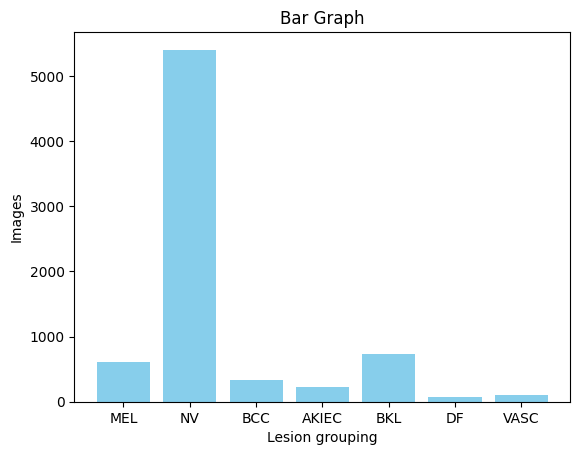

In [18]:
y_value=[]
x_value= ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
for key,values in image_dict.items():
    y_value.append(len(values))

plt.bar(x_value, y_value, color='skyblue')

plt.xlabel('Lesion grouping')
plt.ylabel('Images')
plt.title('Bar Graph')

plt.show()


Data Visualization

In [19]:
def plot_data(data,names):
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(3):
        for j in range(3):
            image=data[i*3 + j] 
            image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
            axs[i, j].imshow(image)
            axs[i, j].set_title(f'Image {i*3 + j + 1}')
            axs[i, j].axis('off')

    fig.suptitle(f'Grid of Images of {names}', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

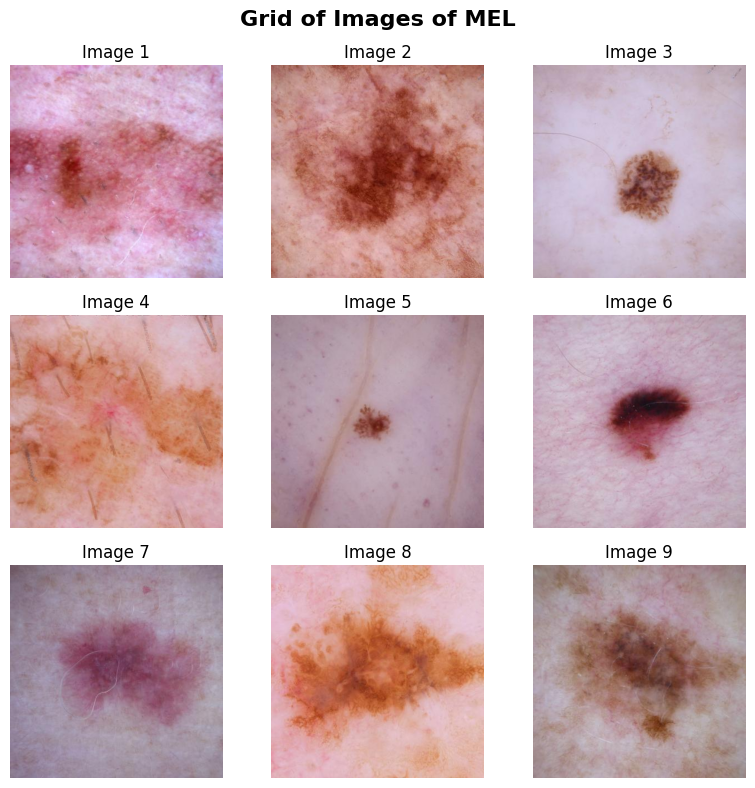

In [20]:
indice=0
plot_data(image_dict[x_value[indice]],x_value[indice])

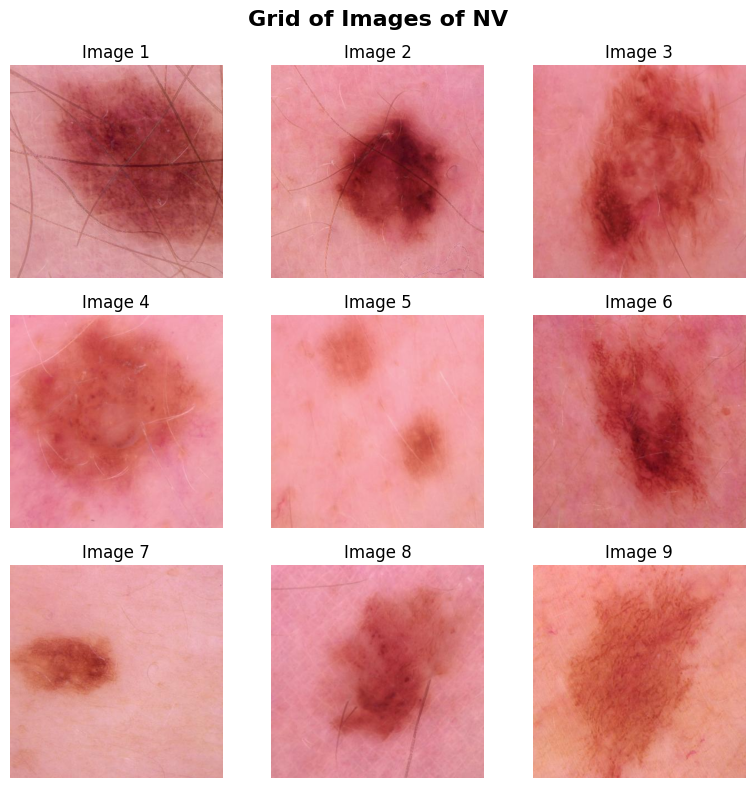

In [21]:
indice=1
plot_data(image_dict[x_value[indice]],x_value[indice])

In [22]:
indice=2
plot_data(image_dict[x_value[indice]],x_value[indice])

In [23]:
indice=3
plot_data(image_dict[x_value[indice]],x_value[indice])

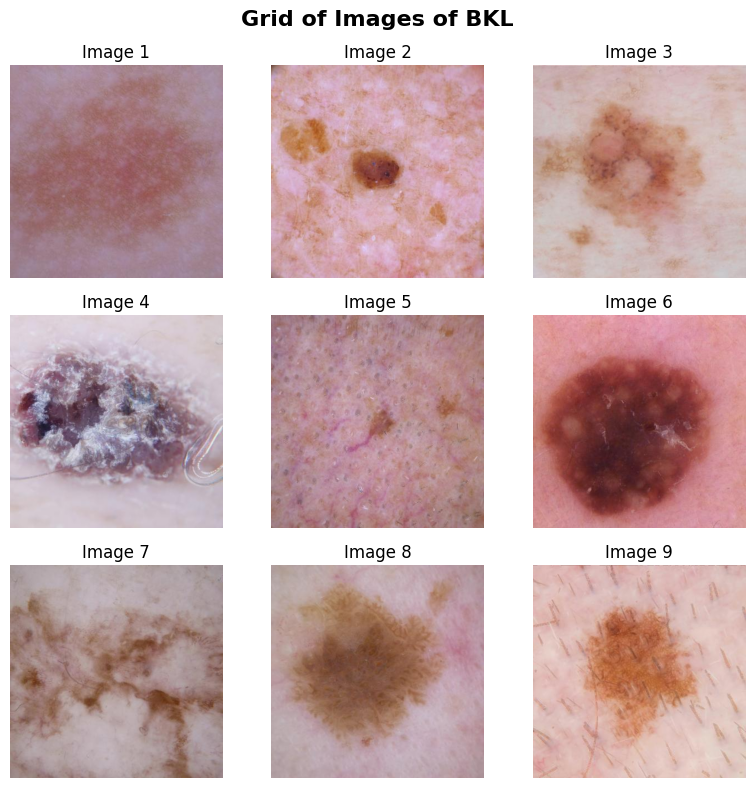

In [24]:
indice=4
plot_data(image_dict[x_value[indice]],x_value[indice])

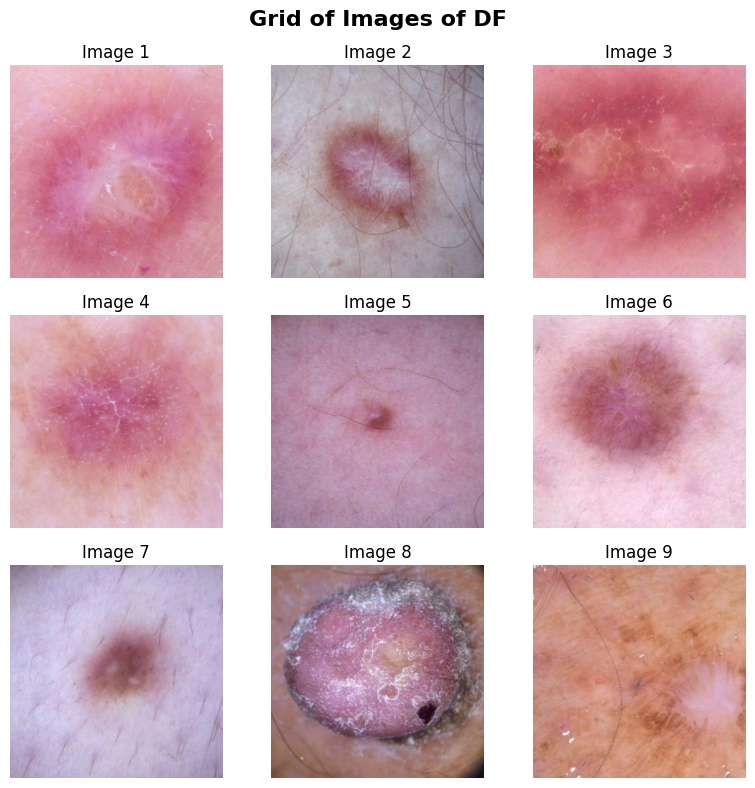

In [25]:
indice=5
plot_data(image_dict[x_value[indice]],x_value[indice])

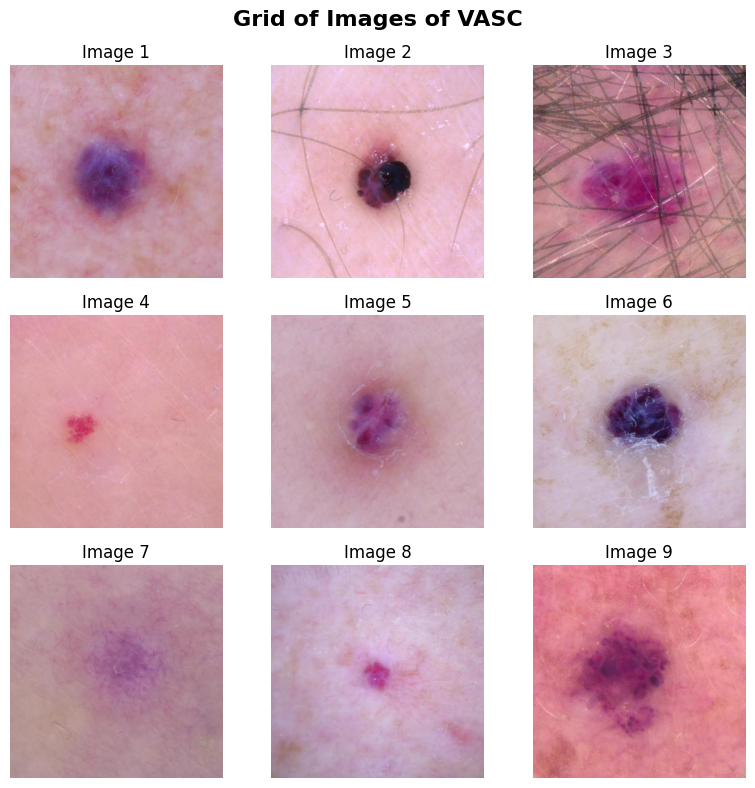

In [26]:
indice=6
plot_data(image_dict[x_value[indice]],x_value[indice])

In [27]:
X_values=np.array(X_values)
print(X_values.shape)

(7470, 384, 384, 3)


In [28]:
X_train=[]
for j in range(len(X_values)):
    value=cv.resize(X_values[j],(150,150))
    X_train.append(value)
X_train=np.array(X_train)
X_train.shape
X_train = X_train.astype('float32') / 255.0

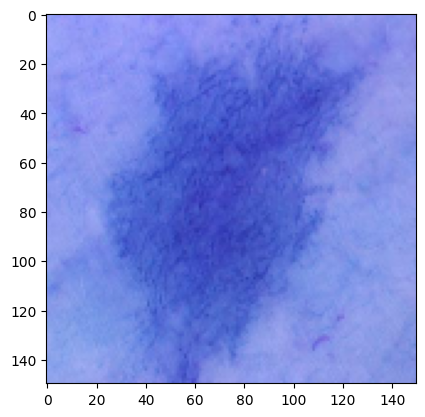

In [29]:
plt.imshow(X_train[10])

In [30]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(Y_values)
print(y_classes)


[5 5 5 ... 5 5 5]


In [31]:
y_classes.shape

(7470,)

Test Data

In [32]:
rd=pd.read_csv(r'/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Testing_GroundTruth.csv')
df_ground_truth=pd.DataFrame(rd)
df_ground_truth.head(10)

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034524  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0034525  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0034526  0.0  0.0  0.0    0.0  1.0  0.0   0.0
3  ISIC_0034527  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0034528  0.0  1.0  0.0    0.0  0.0  0.0   0.0
5  ISIC_0034529  1.0  0.0  0.0    0.0  0.0  0.0   0.0
6  ISIC_0034530  0.0  1.0  0.0    0.0  0.0  0.0   0.0
7  ISIC_0034531  0.0  0.0  0.0    0.0  1.0  0.0   0.0
8  ISIC_0034532  0.0  1.0  0.0    0.0  0.0  0.0   0.0
9  ISIC_0034533  0.0  1.0  0.0    0.0  0.0  0.0   0.0

In [33]:
df_ground_truth['result']=one_hot_to_sparse(df_ground_truth)
df_ground_truth

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC result
0     ISIC_0034524  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1     ISIC_0034525  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2     ISIC_0034526  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
3     ISIC_0034527  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4     ISIC_0034528  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
...            ...  ...  ...  ...    ...  ...  ...   ...    ...
1507  ISIC_0036060  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
1508  ISIC_0036061  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1509  ISIC_0036062  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC
1510  ISIC_0036063  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
1511  ISIC_0036064  0.0  0.0  1.0    0.0  0.0  0.0   0.0    BCC

[1512 rows x 9 columns]

In [34]:
X_test=[]
Y_test=[]
test_folder=r'/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test'
files=os.listdir(test_folder)
for file in files:
    file_name=file.split('.')
    image_id=file_name[0]
    index = np.argwhere(df_ground_truth.values == image_id)
    result=df_ground_truth['result'].values
    key=result[index[0][0]]
    image_path=get_file_path(test_folder,file)
    image_data=cv.imread(image_path)
    X_test.append(image_data)
    Y_test.append(key)
    
X_test=np.array(X_test)
X_test.shape
    

(1512, 384, 384, 3)

In [35]:
input_shape=(150, 150, 3)

In [36]:
X_testing=[]
for j in range(len(X_test)):
    value=cv.resize(X_test[j],(150,150))
    X_testing.append(value)
X_testing=np.array(X_testing)
X_testing.shape

(1512, 150, 150, 3)

In [37]:
X_testing=X_testing.astype('float32') / 255.0 
y_test= label_encoder.fit_transform(Y_test)
print(y_test)

[5 5 5 ... 5 5 5]


In [38]:
def plots(model_his):
    plt.figure(figsize=(14, 3))

    plt.subplot(1, 2, 1)
    plt.plot(model_his.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left') 

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(model_his.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  

    plt.show()
    
# plots(resnet18_train)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def confusion_classifiaction(model,X_testing,y_test):
    
    y_pred=model.predict(X_testing)
    y_pred_labels=[np.argmax(i) for i in y_pred]


    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print('--------------------------------------------------------------')
    report = classification_report(y_test, y_pred_labels)
    print(report)


# confusion_classifiaction(resnet18,X_testing,y_test)

Resnet18 without dilation

In [40]:

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def identity_block(x, filters, kernel_size=3, stride=1, l2_reg=1e-4):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1, l2_reg=1e-4):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                           kernel_regularizer=regularizers.l2(l2_reg))(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x    

def ResNet18(input_shape=(150,150,3), kernel_size=(3,3), num_classes=7, l2_reg=1e-4):
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1, l2_reg=l2_reg)
    x = identity_block(x, filters=64, kernel_size=3, l2_reg=l2_reg)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1, l2_reg=l2_reg)
    x = identity_block(x, filters=128, kernel_size=3, l2_reg=l2_reg)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1, l2_reg=l2_reg)
    x = identity_block(x, filters=256, kernel_size=3, l2_reg=l2_reg)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=512, kernel_size=3, stride=1, l2_reg=l2_reg)
    x = identity_block(x, filters=512, kernel_size=3, l2_reg=l2_reg)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet18')
    return model

# Example usage:
resnet18_with_regularization = ResNet18(input_shape=(150, 150, 3), num_classes=7, l2_reg=1e-4)



In [41]:
resnet18_with_regularization.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet18_with_regularization_train=resnet18_with_regularization.fit(X_train[:6000],y_classes[:6000],batch_size=32, epochs=25,validation_data=(X_train[6000:], y_classes[6000:]))

Epoch 1/25
  1/188 ━━━━━━━━━━━━━━━━━━━━ 1:44:23 33s/step - accuracy: 0.1562 - loss: 8.9959

I0000 00:00:1712998206.883882    1701 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 226ms/step - accuracy: 0.6768 - loss: 1.8470 - val_accuracy: 0.7218 - val_loss: 1.6880
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7486 - loss: 1.1569 - val_accuracy: 0.7401 - val_loss: 1.2321
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7619 - loss: 1.0499 - val_accuracy: 0.7789 - val_loss: 1.0124
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7680 - loss: 1.0004 - val_accuracy: 0.7565 - val_loss: 1.0739
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7712 - loss: 0.9555 - val_accuracy: 0.7476 - val_loss: 0.9346
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7922 - loss: 0.8632 - val_accuracy: 0.7578 - val_loss: 0.9109
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7864 - loss: 0.8533 - val_accuracy: 0.7667 - val_loss: 0.9895
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7856 - loss: 0.7980 - val_accura

In [42]:
def plots2(model_his):
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 2, 1)
    plt.plot(model_his.history['accuracy'])
    plt.plot(model_his.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(2, 2, 2)
    plt.plot(model_his.history['loss'])
    plt.plot(model_his.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


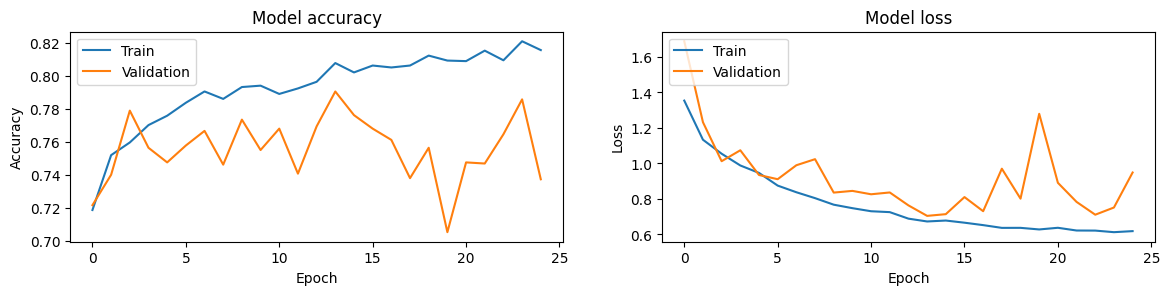

In [43]:
plots2(resnet18_with_regularization_train)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step


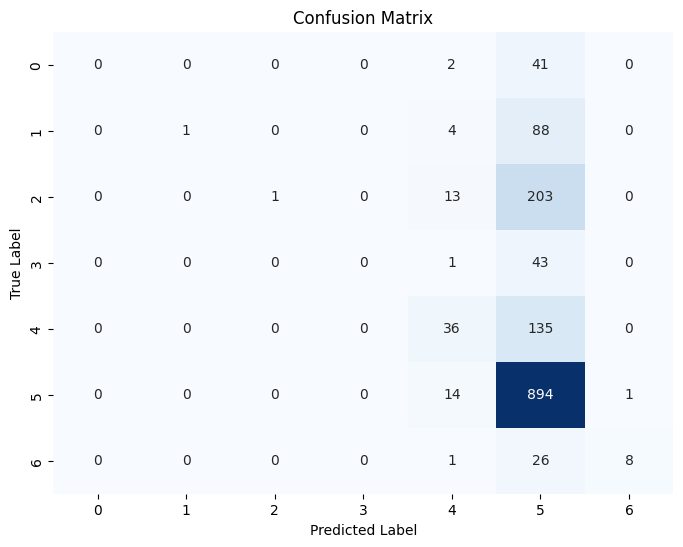

--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       1.00      0.01      0.02        93
           2       1.00      0.00      0.01       217
           3       0.00      0.00      0.00        44
           4       0.51      0.21      0.30       171
           5       0.63      0.98      0.76       909
           6       0.89      0.23      0.36        35

    accuracy                           0.62      1512
   macro avg       0.57      0.21      0.21      1512
weighted avg       0.66      0.62      0.50      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
confusion_classifiaction(resnet18_with_regularization,X_testing,y_test)

In [73]:
m1=resnet18_with_regularization.evaluate(X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6227 - loss: 1.4254


Resnet with dilation

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

def conv_block(input_tensor, filters, stride, kernel_regularizer=l2(1e-4)):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_regularizer=l2(1e-4)):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def ResNet18(input_shape, num_classes, dilation_rate=2, kernel_regularizer=l2(1e-4)):
    input_tensor = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = conv_block(x, 64, stride=(1, 1), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 64, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 128, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 128, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 256, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 256, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 512, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 512, kernel_regularizer=kernel_regularizer)
    
    # Dilated convolution
    x = layers.Conv2D(512, kernel_size=(3, 3), dilation_rate=dilation_rate, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    
    model = Model(input_tensor, x)
    return model

# Example usage
input_shape = (150, 150, 3)
num_classes = 7
resnet18_dialation_reg= ResNet18(input_shape, num_classes)



In [47]:
resnet18_dialation_reg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet18_dialation_reg_train=resnet18_dialation_reg.fit(X_train[:6000],y_classes[:6000],batch_size=32, epochs=25,validation_data=(X_train[6000:], y_classes[6000:]))

Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 170ms/step - accuracy: 0.6640 - loss: 2.0405 - val_accuracy: 0.7211 - val_loss: 2.9208
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7409 - loss: 1.5203 - val_accuracy: 0.7252 - val_loss: 1.3925
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7598 - loss: 1.2391 - val_accuracy: 0.7034 - val_loss: 1.2807
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7584 - loss: 1.0927 - val_accuracy: 0.6803 - val_loss: 1.2616
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7664 - loss: 0.9740 - val_accuracy: 0.6844 - val_loss: 1.1045
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7798 - loss: 0.8721 - val_accuracy: 0.7463 - val_loss: 0.9545
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7904 - loss: 0.8221 - val_accuracy: 0.7408 - val_loss: 0.9300
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7869 - loss: 0.7848 - 

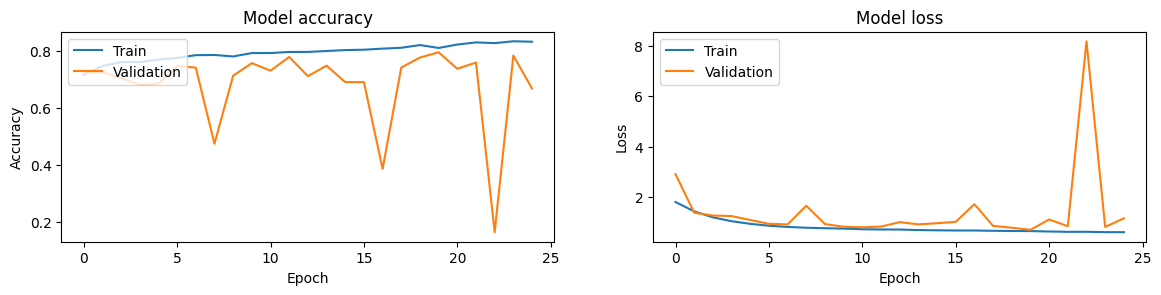

In [48]:
plots2(resnet18_dialation_reg_train)

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step


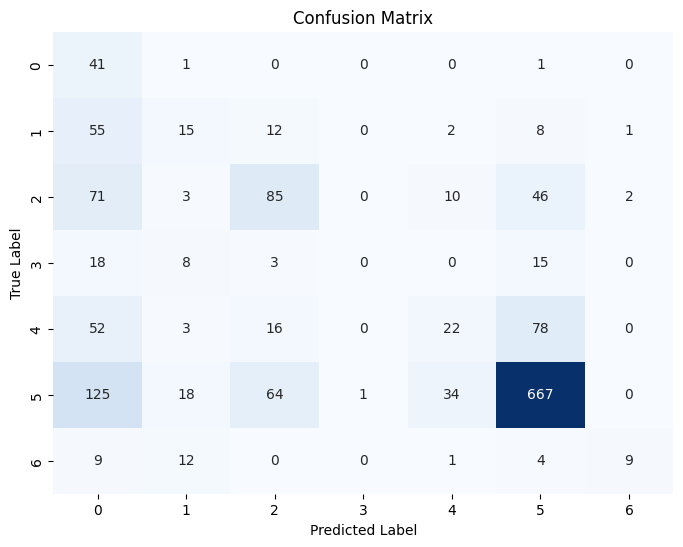

--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.95      0.20        43
           1       0.25      0.16      0.20        93
           2       0.47      0.39      0.43       217
           3       0.00      0.00      0.00        44
           4       0.32      0.13      0.18       171
           5       0.81      0.73      0.77       909
           6       0.75      0.26      0.38        35

    accuracy                           0.55      1512
   macro avg       0.39      0.38      0.31      1512
weighted avg       0.63      0.55      0.57      1512



In [49]:
confusion_classifiaction(resnet18_dialation_reg,X_testing,y_test)

In [72]:
m2=resnet18_dialation_reg.evaluate(X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5578 - loss: 1.5977


Using Dense Layers instead of Global pooling layers

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

def conv_block(input_tensor, filters, stride, kernel_regularizer=l2(1e-4)):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_regularizer=l2(1e-4)):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def ResNet18(input_shape, num_classes, dilation_rate=1, kernel_regularizer=l2(1e-4)):
    input_tensor = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = conv_block(x, 64, stride=(1, 1), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 64, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 128, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 128, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 256, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 256, kernel_regularizer=kernel_regularizer)
    
    x = conv_block(x, 512, stride=(2, 2), kernel_regularizer=kernel_regularizer)
    x = identity_block(x, 512, kernel_regularizer=kernel_regularizer)
    
    # Dilated convolution
    x = layers.Conv2D(512, kernel_size=(3, 3), dilation_rate=dilation_rate, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Flatten the output
    x = layers.Flatten()(x)
    
    # Add Dense layers
    x = layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(100, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=kernel_regularizer)(x)
    
    model = Model(input_tensor, x)
    return model

# Example usage
input_shape = (150, 150, 3)
num_classes = 7
resnet18_dilation_reg_dense = ResNet18(input_shape, num_classes)


In [52]:
resnet18_dilation_reg_dense.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet18_dialation_reg_dense_train=resnet18_dilation_reg_dense.fit(X_train[:6000],y_classes[:6000],batch_size=32, epochs=25,validation_data=(X_train[6000:], y_classes[6000:]))

Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6651 - loss: 3.0245

W0000 00:00:1712999067.425313    1699 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.6653 - loss: 3.0221 - val_accuracy: 0.7218 - val_loss: 3.7446
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7238 - loss: 2.2902 - val_accuracy: 0.7218 - val_loss: 2.1738
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7115 - loss: 1.9485 - val_accuracy: 0.7218 - val_loss: 1.8355
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7342 - loss: 1.8563 - val_accuracy: 0.7218 - val_loss: 1.7655
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7153 - loss: 1.8414 - val_accuracy: 0.7218 - val_loss: 1.6488
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7151 - loss: 1.6441 - val_accuracy: 0.7252 - val_loss: 1.5850
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7201 - loss: 1.4728 - val_accuracy: 0.7231 - val_loss: 1.3844
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7280 - loss: 1.3545 - val_accuracy: 0.7

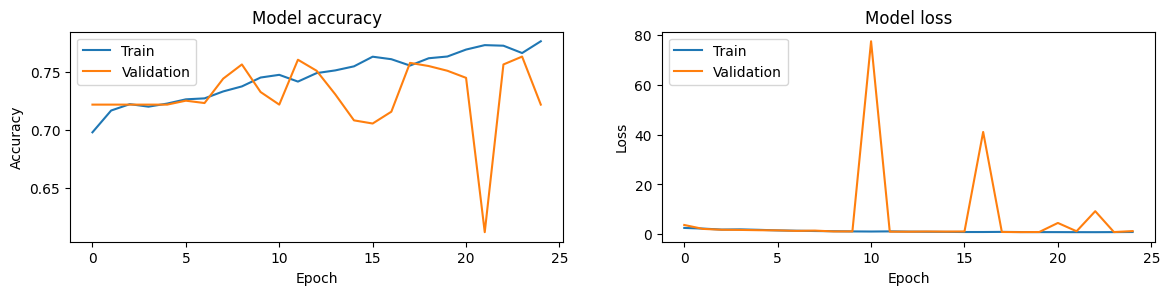

In [53]:
plots2(resnet18_dialation_reg_dense_train)

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


W0000 00:00:1712999304.173666    1700 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


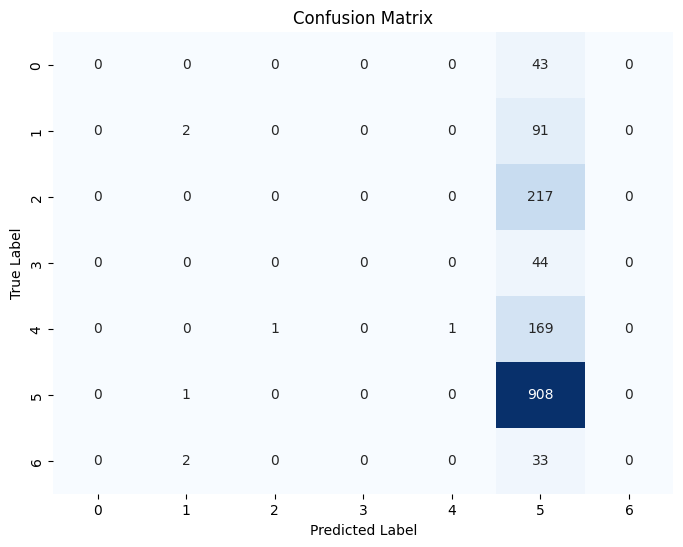

--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.40      0.02      0.04        93
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00        44
           4       1.00      0.01      0.01       171
           5       0.60      1.00      0.75       909
           6       0.00      0.00      0.00        35

    accuracy                           0.60      1512
   macro avg       0.29      0.15      0.11      1512
weighted avg       0.50      0.60      0.46      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
confusion_classifiaction(resnet18_dilation_reg_dense,X_testing,y_test)

In [71]:
m3=resnet18_dilation_reg_dense.evaluate(X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6048 - loss: 1.5248


Resnet152 with dilation

In [56]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam

def identity_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def dilated_convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet152_With_Dilation(inputShape=(150,150,3),kernelSize=(3,3), num_classes=7):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1)
    x = identity_block(x, filters=64, kernel_size=3)
    x = identity_block(x, filters=64, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = dilated_convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3)
    x = identity_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet152')
    return model

resnet152 = ResNet152_With_Dilation(inputShape=(150, 150, 3), num_classes=7)

# resnet152.summary()

In [57]:
resnet152.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet152_dense_train=resnet152.fit(X_train[:6000],y_classes[:6000],batch_size=32, epochs=25,validation_data=(X_train[6000:], y_classes[6000:]))

Epoch 1/25


W0000 00:00:1712999500.318689    1700 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6887 - loss: 1.8814   

W0000 00:00:1712999716.454684    1698 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.6888 - loss: 1.8778 - val_accuracy: 0.7218 - val_loss: 1.1464
Epoch 2/25


W0000 00:00:1712999733.773363    1701 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 679ms/step - accuracy: 0.7339 - loss: 0.7799 - val_accuracy: 0.7218 - val_loss: 1.1554
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 680ms/step - accuracy: 0.7421 - loss: 0.7032 - val_accuracy: 0.7245 - val_loss: 0.8135
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 679ms/step - accuracy: 0.7486 - loss: 0.6829 - val_accuracy: 0.7218 - val_loss: 93251330048.0000
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 680ms/step - accuracy: 0.6979 - loss: 1.1936 - val_accuracy: 0.7347 - val_loss: 209.2522
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 680ms/step - accuracy: 0.7426 - loss: 0.8038 - val_accuracy: 0.7537 - val_loss: 0.8098
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 680ms/step - accuracy: 0.7307 - loss: 0.7753 - val_accuracy: 0.7415 - val_loss: 0.7914
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 679ms/step - accuracy: 0.7255 - loss: 0.7955 - val_accuracy: 0.7245 - val_loss: 1.0254
Epoch 9/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 128s 679ms/step - accuracy: 0.7389 

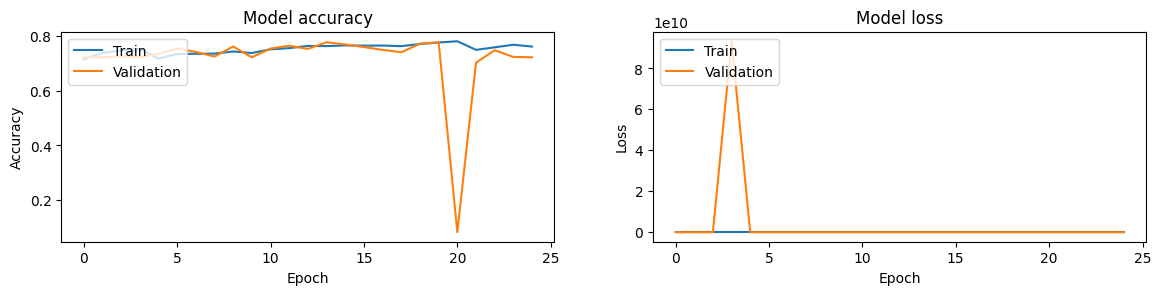

In [58]:
plots2(resnet152_dense_train)

48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step


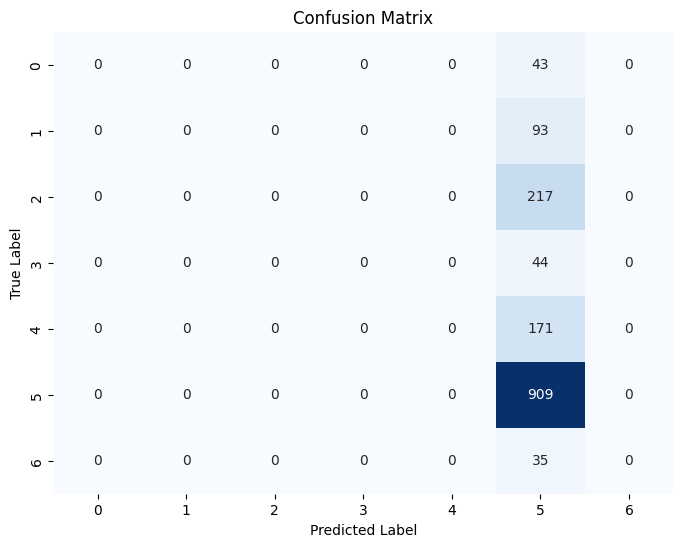

--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.00      0.00      0.00        93
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00        44
           4       0.00      0.00      0.00       171
           5       0.60      1.00      0.75       909
           6       0.00      0.00      0.00        35

    accuracy                           0.60      1512
   macro avg       0.09      0.14      0.11      1512
weighted avg       0.36      0.60      0.45      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
confusion_classifiaction(resnet152,X_testing,y_test)

In [70]:
m4=resnet152.evaluate(X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.6043 - loss: 2.1256


Resnet152 without Dialation

In [61]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam

def identity_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet152_Without_Dilation(inputShape=(150,150,3),kernelSize=(3,3), num_classes=7):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1)
    x = identity_block(x, filters=64, kernel_size=3)
    x = identity_block(x, filters=64, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3)
    x = identity_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet152')
    return model

resnet152_without = ResNet152_Without_Dilation(inputShape=(150, 150, 3), num_classes=7)



In [62]:
resnet152_without.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet152_without_train=resnet152_without.fit(X_train[:6000],y_classes[:6000],batch_size=32, epochs=25,validation_data=(X_train[6000:], y_classes[6000:]))

Epoch 1/25


W0000 00:00:1713003036.325101    1699 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6717 - loss: 1.9309   

W0000 00:00:1713003242.370464    1699 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.6719 - loss: 1.9270 - val_accuracy: 0.7218 - val_loss: 1.3125
Epoch 2/25


W0000 00:00:1713003255.975160    1698 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 672ms/step - accuracy: 0.7386 - loss: 0.7939 - val_accuracy: 0.7218 - val_loss: 15.9365
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 673ms/step - accuracy: 0.7435 - loss: 0.7582 - val_accuracy: 0.7463 - val_loss: 0.7243
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 673ms/step - accuracy: 0.7414 - loss: 0.7536 - val_accuracy: 0.6837 - val_loss: 12.8044
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 673ms/step - accuracy: 0.7439 - loss: 0.8802 - val_accuracy: 0.7129 - val_loss: 0.8500
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 127s 673ms/step - accuracy: 0.7479 - loss: 0.7460 - val_accuracy: 0.7605 - val_loss: 0.6467
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 673ms/step - accuracy: 0.7655 - loss: 0.6729 - val_accuracy: 0.7592 - val_loss: 0.6728
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 127s 673ms/step - accuracy: 0.7497 - loss: 0.7379 - val_accuracy: 0.7224 - val_loss: 27.6489
Epoch 9/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 127s 673ms/step - accuracy: 0.7574 - loss: 0

In [63]:
plots2(resnet152_without_train)

In [64]:
confusion_classifiaction(resnet152_without,X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step


--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.25      0.01      0.02        93
           2       0.27      0.11      0.16       217
           3       0.00      0.00      0.00        44
           4       0.32      0.15      0.20       171
           5       0.65      0.96      0.78       909
           6       0.00      0.00      0.00        35

    accuracy                           0.61      1512
   macro avg       0.21      0.18      0.16      1512
weighted avg       0.48      0.61      0.51      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
m5=resnet152_without.evaluate(X_testing,y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.6120 - loss: 5.6731


In [90]:
print("Accuray of different models")
x_models=['resnet18 with reg','resnet18 with dia','resnet18 with dense ','resnet152','resnet152 with dilation ']
y_accuracy=[m1[1]*100,m2[1]*100,m3[1]*100,m4[1]*100,m5[1]*100]


Accuray of different models


Text(0.5, 1.0, 'Bar Graph')

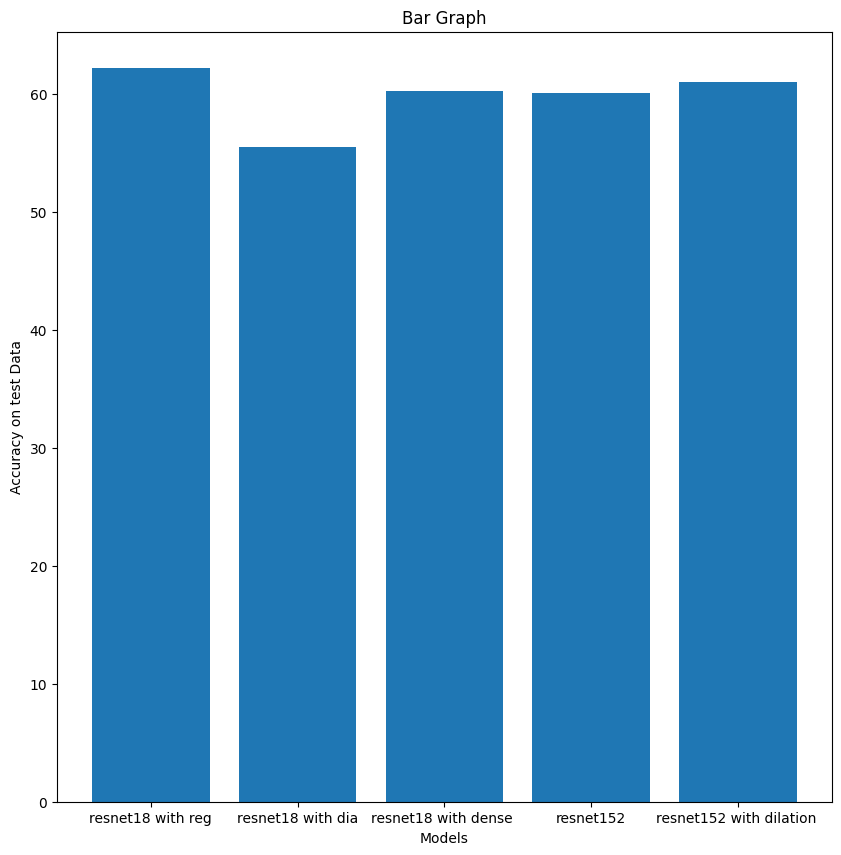

In [91]:

plt.figure(figsize=(10, 10))
plt.bar(x_models,y_accuracy)


plt.xlabel('Models')
plt.ylabel('Accuracy on test Data')
plt.title('Bar Graph')
